In [10]:
import json
import os
import random
from datetime import datetime, timedelta

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

pd.options.mode.chained_assignment = None

# load data

In [3]:
x_train = pd.read_parquet("../data/selected_features_regression/x_train/data.parquet")
x_cv = pd.read_parquet("../data/selected_features_regression/x_cv/data.parquet")
x_test = pd.read_parquet("../data/selected_features_regression/x_test/data.parquet")

y_train = pd.read_parquet("../data/selected_features_regression/y_train/data.parquet")[
    "tenure"
]
y_cv = pd.read_parquet("../data/selected_features_regression/y_cv/data.parquet")[
    "tenure"
]
y_test = pd.read_parquet("../data/selected_features_regression/y_test/data.parquet")[
    "tenure"
]

x_train = pd.concat([x_train, x_cv])
y_train = pd.concat([y_train, y_cv])

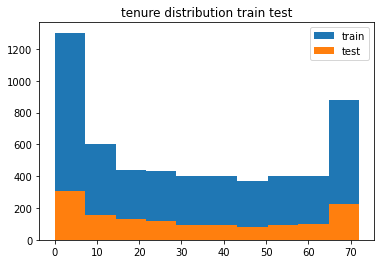

In [4]:
plt.figure()
plt.title(f"tenure distribution train test")
plt.hist(y_train)
plt.hist(y_test)
plt.legend(["train", "test"])
plt.show()

# Time series split

In [5]:
x_train.columns

Index(['TotalCharges', 'MonthlyCharges', 'Contract_0', 'Contract_1',
       'InternetService_1', 'MultipleLines_1'],
      dtype='object')

In [6]:
tscv = TimeSeriesSplit(n_splits=10)
tscv

TimeSeriesSplit(max_train_size=None, n_splits=10)

# Training Random Forest Model

## tuning num_estimators

In [11]:
num_estimators_list = [20, 30, 40, 50, 60, 70, 100, 150, 200, 250, 300, 400, 450, 500]

tscv_loss_dict = {}
for ix, ne in enumerate(num_estimators_list):
    print(f"num_estimators {ne}")

    tscv_loss_list = []

    for train_index, cv_index in tscv.split(x_train):

        # get data for cv ready
        x_train_req = x_train.iloc[train_index]
        x_cv_req = x_train.iloc[cv_index]

        y_train_req = y_train.iloc[train_index]
        y_cv_req = y_train.iloc[cv_index]

        # print(f"len_train {len(train_index)}, len_cv {len(cv_index)}")
        clf = RandomForestRegressor(n_estimators=ne,)
        clf.fit(x_train_req, y_train_req)

        # get log los train
        y_pred_train_mse = clf.predict(x_train_req)
        mse_train = mean_squared_error(y_train_req, y_pred_train_mse)

        # get log los cv set
        y_pred_val_mse = clf.predict(x_cv_req)
        mse_cv = mean_squared_error(y_cv_req, y_pred_val_mse)

        tscv_loss_list.append({"mse_train": mse_train, "mse_cv": mse_cv})

    tscv_loss_dict[ix] = tscv_loss_list

num_estimators 20
num_estimators 30
num_estimators 40
num_estimators 50
num_estimators 60
num_estimators 70
num_estimators 100
num_estimators 150
num_estimators 200
num_estimators 250
num_estimators 300
num_estimators 400
num_estimators 450
num_estimators 500


In [12]:
df_tscv = pd.DataFrame(tscv_loss_dict.items()).rename(
    columns={0: "iteration", 1: "losses"}
)

df_tscv["mse_train"] = df_tscv["losses"].apply(
    lambda x: np.mean([i["mse_train"] for i in x])
)
df_tscv["mse_cv"] = df_tscv["losses"].apply(lambda x: np.mean([i["mse_cv"] for i in x]))


df_tscv["num_estimators"] = num_estimators_list
df_tscv = df_tscv.drop(columns=["losses"])
df_tscv

,iteration,mse_train,mse_cv,num_estimators
0,0,0.922692,4.946294,20
1,1,0.899382,5.075150,30
2,2,0.846149,5.180966,40
3,3,0.863566,4.882669,50
4,4,0.835182,4.970527,60
5,5,0.843003,4.914481,70
6,6,0.791892,4.765823,100
7,7,0.796063,4.936121,150
8,8,0.813744,4.934903,200
9,9,0.793927,4.820910,250


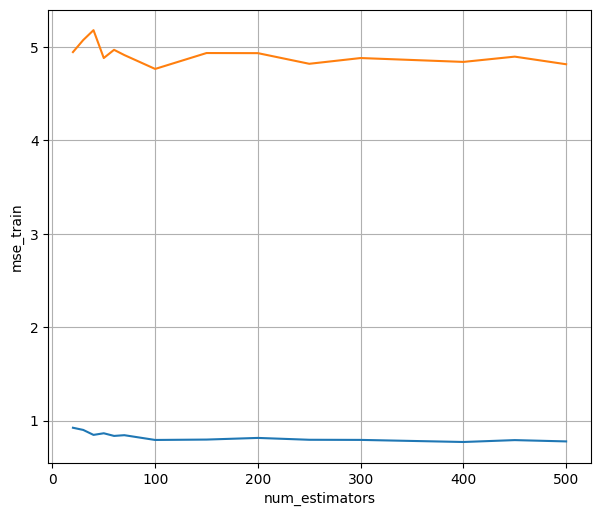

In [13]:
plt.figure(figsize=[7, 6], dpi=100)
sns.lineplot(y="mse_train", x="num_estimators", data=df_tscv)
sns.lineplot(y="mse_cv", x="num_estimators", data=df_tscv)
plt.grid()

Using `n_estimators = 100` as best param

## re-train with best num_estimators

In [15]:
x_train = pd.read_parquet("../data/selected_features_regression/x_train/data.parquet")
x_cv = pd.read_parquet("../data/selected_features_regression/x_cv/data.parquet")
x_test = pd.read_parquet("../data/selected_features_regression/x_test/data.parquet")

y_train = pd.read_parquet("../data/selected_features_regression/y_train/data.parquet")[
    "tenure"
]
y_cv = pd.read_parquet("../data/selected_features_regression/y_cv/data.parquet")[
    "tenure"
]
y_test = pd.read_parquet("../data/selected_features_regression/y_test/data.parquet")[
    "tenure"
]

x_train = pd.concat([x_train, x_cv])
y_train = pd.concat([y_train, y_cv])

In [16]:
clf = RandomForestRegressor(n_estimators=100)
clf.fit(x_train, y_train)

y_pred_train = clf.predict(x_train)
y_pred_test = clf.predict(x_test)

y_pred_proba_train = clf.predict(x_train)
y_pred_proba_test = clf.predict(x_test)

## Check mse

In [17]:
mean_squared_error_train = mean_squared_error(y_train, y_pred_proba_train)
mean_squared_error_test = mean_squared_error(y_test, y_pred_proba_test)

print(f"mse train {mean_squared_error_train}")
print(f"mse test {mean_squared_error_test}")

mse train 0.43859250976215824
mse test 5.557558339247693


# Fine tuning Random Forest Model

In [21]:
# using best n_estimators got from training

clf = RandomForestRegressor(n_estimators=100)


param_grid = {
    "max_depth": [100, 200, 300, None],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3, 4, 5],
}

grid_search_clf = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=None,
    refit=True,
    scoring="neg_mean_squared_error",
)
grid_search_clf.fit(x_train, y_train)

%time

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


In [23]:
grid_search_clf.best_params_

{'max_depth': 300, 'min_samples_leaf': 2, 'min_samples_split': 4}

In [25]:
y_pred_train = grid_search_clf.predict(x_train)
y_pred_test = grid_search_clf.predict(x_test)

## Check mse

In [26]:
mean_squared_error_train = mean_squared_error(y_train, y_pred_train)
mean_squared_error_test = mean_squared_error(y_test, y_pred_test)

print(f"mse train {mean_squared_error_train}")
print(f"mse test {mean_squared_error_test}")

mse train 0.7663186354750641
mse test 5.595728203284152


# Save model

In [27]:
os.makedirs("../data/models/reg/random_forest/", exist_ok=True)

In [29]:
joblib.dump(
    grid_search_clf.best_estimator_, "../data/models/reg/random_forest/rf_model.pkl"
)

['../data/models/reg/random_forest/rf_model.pkl']